In [1]:
import os

data_dir = '.\jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

<function matplotlib.pyplot.show(close=None, block=None)>

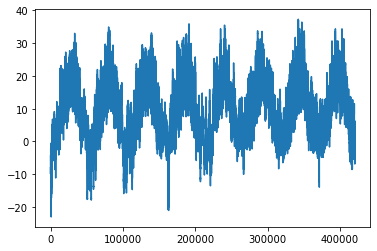

In [3]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

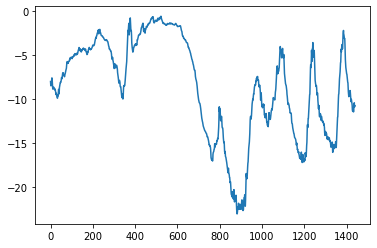

In [4]:
plt.plot(range(1440), temp[:1440])
plt.show

In [5]:
mean  = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [8]:
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [9]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [10]:
cm = 0.29*std[1]
print(cm)

2.5672247338393395


In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import rmsprop_v2

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

C:\Users\julek\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 7s 13ms/step - loss: 1.2928 - val_loss: 0.7009
Epoch 2/20
500/500 [==============================] - 7s 13ms/step - loss: 0.4221 - val_loss: 0.3130
Epoch 3/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2899 - val_loss: 0.2924
Epoch 4/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2669 - val_loss: 0.3047
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2525 - val_loss: 0.3140
Epoch 6/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2447 - val_loss: 0.3072
Epoch 7/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2381 - val_loss: 0.3189
Epoch 8/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2307 - val_loss: 0.3386
Epoch 9/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2265 - val_loss: 0.3481
Epoch 10/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2227 - val_lo

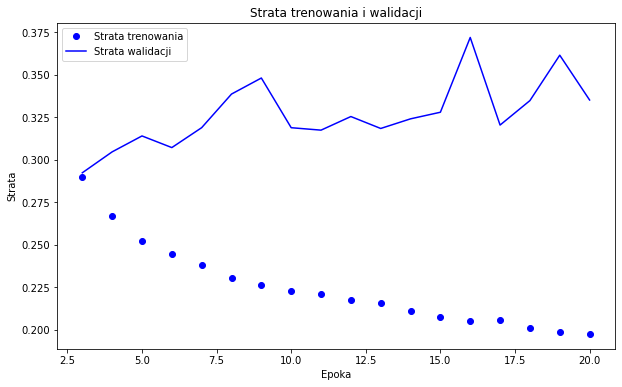

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs[2:], loss[2:], 'bo', label = 'Strata trenowania')
plt.plot(epochs[2:], val_loss[2:], 'b', label = 'Strata walidacji')
plt.legend()
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.savefig("./zdj_6_3/Loss_Flatten_1Dense.jpg")

In [16]:
min(val_loss)

0.292357861995697

In [17]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

C:\Users\julek\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 11s 16ms/step - loss: 0.3020 - val_loss: 0.2684
Epoch 2/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2849 - val_loss: 0.2635
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2783 - val_loss: 0.2643
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2752 - val_loss: 0.2596
Epoch 5/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2722 - val_loss: 0.2622
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2674 - val_loss: 0.2598
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2632 - val_loss: 0.2603
Epoch 8/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2584 - val_loss: 0.2633
Epoch 9/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2546 - val_loss: 0.2692
Epoch 10/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2512 - val_l

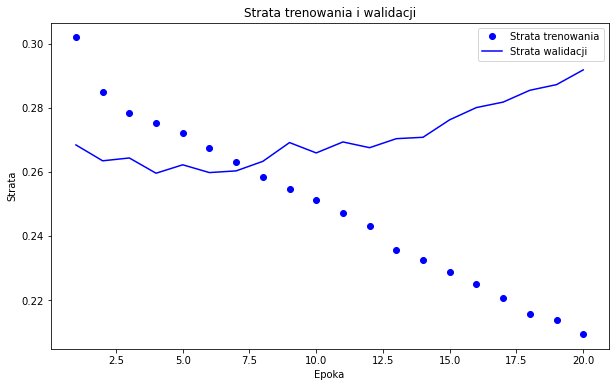

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'bo', label = 'Strata trenowania')
plt.plot(epochs, val_loss, 'b', label = 'Strata walidacji')
plt.legend()
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.savefig("./zdj_6_3/Loss_1GRU.jpg")

In [19]:
min(val_loss)

0.2595836818218231

In [20]:
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 10s 17ms/step - loss: 0.2979 - val_loss: 0.2701
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2751 - val_loss: 0.2691
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2608 - val_loss: 0.2720
Epoch 4/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2514 - val_loss: 0.2772
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2427 - val_loss: 0.2796
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2353 - val_loss: 0.2816
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2304 - val_loss: 0.2838
Epoch 8/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2222 - val_loss: 0.2857
Epoch 9/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2185 - val_loss: 0.2951
Epoch 10/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2121 - val_l

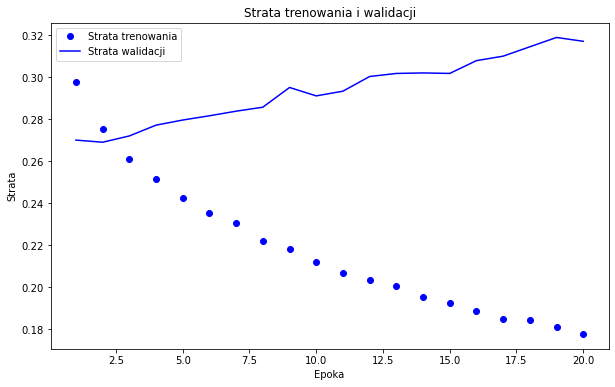

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'bo', label = 'Strata trenowania')
plt.plot(epochs, val_loss, 'b', label = 'Strata walidacji')
plt.legend()
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.savefig("./zdj_6_3/Loss_1LSTM.jpg")

In [22]:
min(val_loss)

0.26905474066734314

In [23]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

C:\Users\julek\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 9s 16ms/step - loss: 0.3225 - val_loss: 0.2842
Epoch 2/40
500/500 [==============================] - 7s 15ms/step - loss: 0.3030 - val_loss: 0.2748
Epoch 3/40
500/500 [==============================] - 8s 15ms/step - loss: 0.2942 - val_loss: 0.2727
Epoch 4/40
500/500 [==============================] - 8s 16ms/step - loss: 0.2918 - val_loss: 0.2682
Epoch 5/40
500/500 [==============================] - 8s 15ms/step - loss: 0.2870 - val_loss: 0.2748
Epoch 6/40
500/500 [==============================] - 8s 15ms/step - loss: 0.2819 - val_loss: 0.2753
Epoch 7/40
500/500 [==============================] - 8s 15ms/step - loss: 0.2785 - val_loss: 0.2707
Epoch 8/40
500/500 [==============================] - 8s 15ms/step - loss: 0.2726 - val_loss: 0.2733
Epoch 9/40
500/500 [==============================] - 8s 15ms/step - loss: 0.2700 - val_loss: 0.2775
Epoch 10/40
500/500 [==============================] - 8s 16ms/step - loss: 0.2660 - val_lo

In [26]:
min(val_loss)

0.26823917031288147

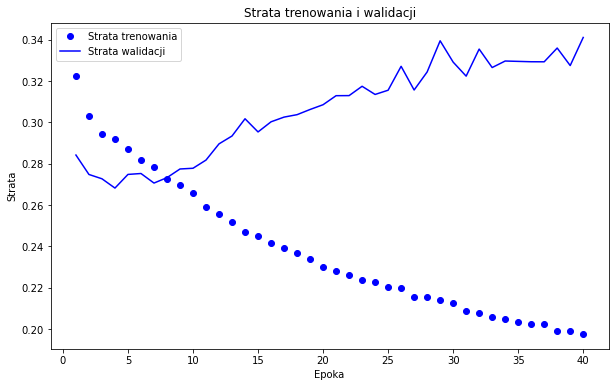

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'bo', label = 'Strata trenowania')
plt.plot(epochs, val_loss, 'b', label = 'Strata walidacji')
plt.legend()
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.savefig("./zdj_6_3/Loss_1GRU_dropout02.jpg")

In [41]:
model = Sequential()
model.add(layers.GRU(32, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

import tensorflow as tf
with tf.device('/cpu:0'):
    model.compile(optimizer='rmsprop', loss='mae')
    history = model.fit_generator(train_gen,
                                  steps_per_epoch=500,
                                  epochs=40,
                                  validation_data=val_gen,
                                  validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 175s 347ms/step - loss: 0.3085 - val_loss: 0.2723
Epoch 2/40
500/500 [==============================] - 172s 345ms/step - loss: 0.2897 - val_loss: 0.2689
Epoch 3/40
500/500 [==============================] - 174s 348ms/step - loss: 0.2814 - val_loss: 0.2697
Epoch 4/40
500/500 [==============================] - 171s 342ms/step - loss: 0.2768 - val_loss: 0.2618
Epoch 5/40
500/500 [==============================] - 170s 341ms/step - loss: 0.2721 - val_loss: 0.2655
Epoch 6/40
500/500 [==============================] - 170s 340ms/step - loss: 0.2680 - val_loss: 0.2668
Epoch 7/40
500/500 [==============================] - 179s 358ms/step - loss: 0.2639 - val_loss: 0.2647
Epoch 8/40
500/500 [==============================] - 168s 336ms/step - loss: 0.2595 - val_loss: 0.2751
Epoch 9/40
500/500 [==============================] - 157s 315ms/step - loss: 0.2548 - val_loss: 0.2738
Epoch 10/40
500/500 [==============================] - 158s 317m

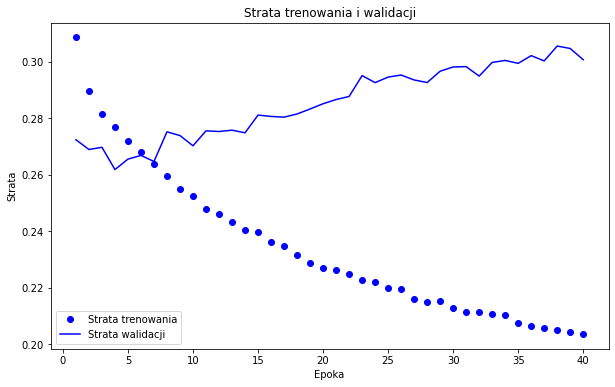

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'bo', label = 'Strata trenowania')
plt.plot(epochs, val_loss, 'b', label = 'Strata walidacji')
plt.legend()
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.savefig("./zdj_6_3/Loss_1GRU_recurrentdropout02.jpg")

In [43]:
min(val_loss)

0.2617742419242859

In [44]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

with tf.device('/cpu:0'):
    model.compile(optimizer='rmsprop', loss='mae')
    history = model.fit_generator(train_gen,
                                  steps_per_epoch=200,
                                  epochs=40,
                                  validation_data=val_gen,
                                  validation_steps=val_steps)

Epoch 1/40
200/200 [==============================] - 122s 605ms/step - loss: 0.3544 - val_loss: 0.2886
Epoch 2/40
200/200 [==============================] - 120s 604ms/step - loss: 0.3146 - val_loss: 0.2825
Epoch 3/40
200/200 [==============================] - 120s 604ms/step - loss: 0.3133 - val_loss: 0.2759
Epoch 4/40
200/200 [==============================] - 120s 604ms/step - loss: 0.3076 - val_loss: 0.2883
Epoch 5/40
200/200 [==============================] - 120s 604ms/step - loss: 0.3023 - val_loss: 0.2748
Epoch 6/40
200/200 [==============================] - 120s 604ms/step - loss: 0.2982 - val_loss: 0.2790
Epoch 7/40
200/200 [==============================] - 120s 604ms/step - loss: 0.2969 - val_loss: 0.2734
Epoch 8/40
200/200 [==============================] - 120s 603ms/step - loss: 0.2952 - val_loss: 0.2928
Epoch 9/40
200/200 [==============================] - 120s 604ms/step - loss: 0.2945 - val_loss: 0.2821
Epoch 10/40
200/200 [==============================] - 120s 603m

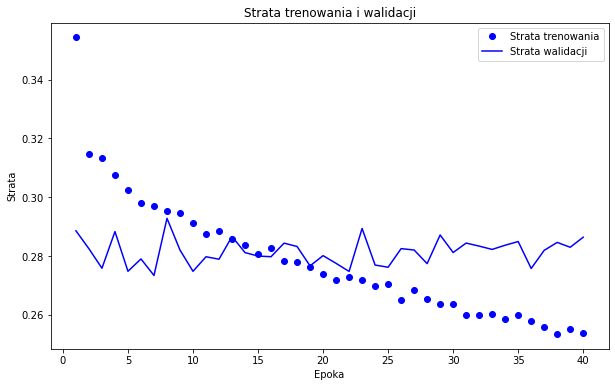

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'bo', label = 'Strata trenowania')
plt.plot(epochs, val_loss, 'b', label = 'Strata walidacji')
plt.legend()
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.savefig("./zdj_6_3/Loss_1GRU_dropout02_recurrentdropout02.jpg")

In [46]:
min(val_loss)

0.27341228723526

In [53]:
model = Sequential()
model.add(layers.LSTM(32, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.LSTM(64, activation='tanh', input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

C:\Users\julek\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 18s 33ms/step - loss: 0.3030 - val_loss: 0.2701
Epoch 2/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2638 - val_loss: 0.2758
Epoch 3/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2439 - val_loss: 0.2816
Epoch 4/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2251 - val_loss: 0.2860
Epoch 5/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2060 - val_loss: 0.3039
Epoch 6/20
500/500 [==============================] - 15s 31ms/step - loss: 0.1889 - val_loss: 0.3037
Epoch 7/20
500/500 [==============================] - 16s 31ms/step - loss: 0.1752 - val_loss: 0.3031
Epoch 8/20
500/500 [==============================] - 15s 31ms/step - loss: 0.1636 - val_loss: 0.3096
Epoch 9/20
500/500 [==============================] - 15s 31ms/step - loss: 0.1542 - val_loss: 0.3083
Epoch 10/20
500/500 [==============================] - 16s 31ms/step - loss: 0.144

In [56]:
min(val_loss)

0.2701025605201721

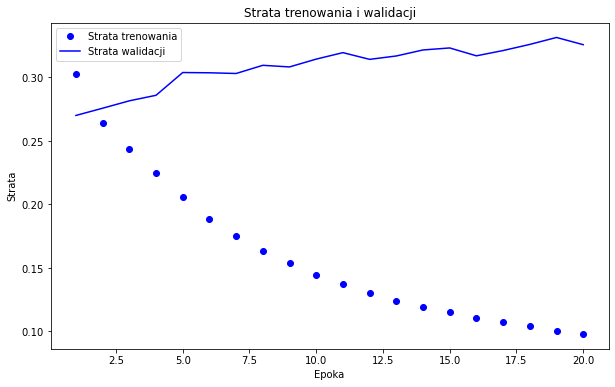

In [57]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'bo', label = 'Strata trenowania')
plt.plot(epochs, val_loss, 'b', label = 'Strata walidacji')
plt.legend()
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.savefig("./zdj_6_3/Loss_2LSTM.jpg")

In [58]:
model = Sequential()
model.add(layers.GRU(32, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='tanh', input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

C:\Users\julek\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 16s 27ms/step - loss: 0.3029 - val_loss: 0.2672
Epoch 2/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2795 - val_loss: 0.2700
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2658 - val_loss: 0.2612
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2561 - val_loss: 0.2731
Epoch 5/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2439 - val_loss: 0.2637
Epoch 6/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2307 - val_loss: 0.2739
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2169 - val_loss: 0.2811
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2038 - val_loss: 0.3014
Epoch 9/20
500/500 [==============================] - 13s 25ms/step - loss: 0.1937 - val_loss: 0.3001
Epoch 10/20
500/500 [==============================] - 13s 25ms/step - loss: 0.182

In [61]:
min(val_loss)

0.2611973285675049

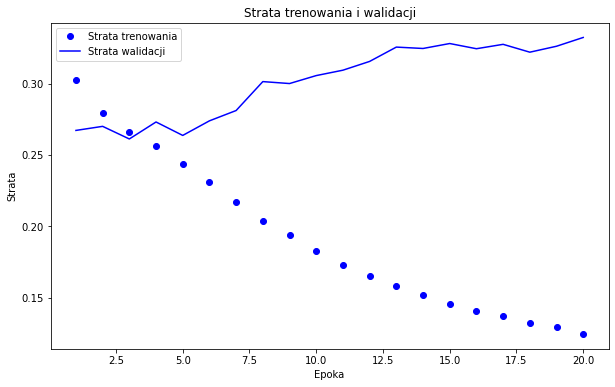

In [60]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'bo', label = 'Strata trenowania')
plt.plot(epochs, val_loss, 'b', label = 'Strata walidacji')
plt.legend()
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.savefig("./zdj_6_3/Loss_2GRU.jpg")

In [62]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32, input_shape=(None, float_data.shape[-1]))))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

C:\Users\julek\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 15s 26ms/step - loss: 0.2971 - val_loss: 0.2793
Epoch 2/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2752 - val_loss: 0.2701
Epoch 3/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2664 - val_loss: 0.2682
Epoch 4/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2620 - val_loss: 0.2629
Epoch 5/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2569 - val_loss: 0.2661
Epoch 6/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2512 - val_loss: 0.2725
Epoch 7/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2447 - val_loss: 0.2685
Epoch 8/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2396 - val_loss: 0.2751
Epoch 9/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2323 - val_loss: 0.2782
Epoch 10/20
500/500 [==============================] - 12s 24ms/step - loss: 0.226

In [64]:
min(val_loss)

0.262940913438797

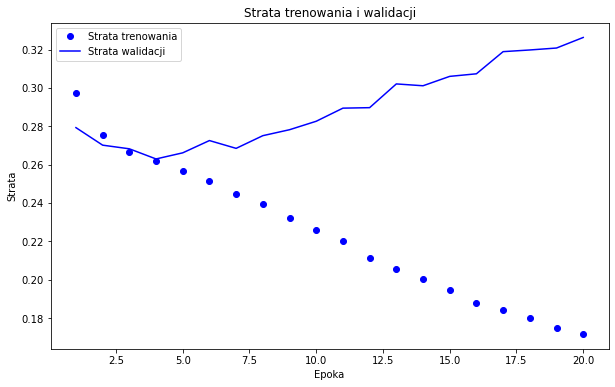

In [65]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'bo', label = 'Strata trenowania')
plt.plot(epochs, val_loss, 'b', label = 'Strata walidacji')
plt.legend()
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.savefig("./zdj_6_3/Loss_GRU_Bidirectional.jpg")

In [66]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(8, input_shape=(None, float_data.shape[-1]))))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 14s 24ms/step - loss: 0.3179 - val_loss: 0.2784
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2833 - val_loss: 0.2728
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2794 - val_loss: 0.2716
Epoch 4/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2772 - val_loss: 0.2722
Epoch 5/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2740 - val_loss: 0.2703
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2746 - val_loss: 0.2697
Epoch 7/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2731 - val_loss: 0.2679
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2701 - val_loss: 0.2677
Epoch 9/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2705 - val_loss: 0.2715
Epoch 10/20
500/500 [==============================] - 11s 23ms/step - loss: 0.268

In [67]:
min(val_loss)

0.262940913438797

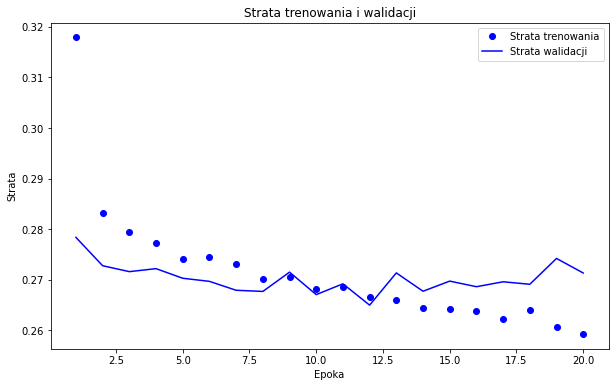

In [68]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'bo', label = 'Strata trenowania')
plt.plot(epochs, val_loss, 'b', label = 'Strata walidacji')
plt.legend()
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.savefig("./zdj_6_3/Loss_GRU_Bidirectional_8units.jpg")

In [69]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(128, input_shape=(None, float_data.shape[-1]))))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 19s 32ms/step - loss: 0.2955 - val_loss: 0.2681
Epoch 2/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2708 - val_loss: 0.2639
Epoch 3/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2525 - val_loss: 0.2770
Epoch 4/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2299 - val_loss: 0.2753
Epoch 5/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2081 - val_loss: 0.2882
Epoch 6/20
500/500 [==============================] - 16s 31ms/step - loss: 0.1842 - val_loss: 0.2984
Epoch 7/20
500/500 [==============================] - 16s 31ms/step - loss: 0.1634 - val_loss: 0.3110
Epoch 8/20
500/500 [==============================] - 16s 31ms/step - loss: 0.1467 - val_loss: 0.3104
Epoch 9/20
500/500 [==============================] - 15s 31ms/step - loss: 0.1347 - val_loss: 0.3134
Epoch 10/20
500/500 [==============================] - 15s 31ms/step - loss: 0.125

In [70]:
min(val_loss)

0.2650068998336792

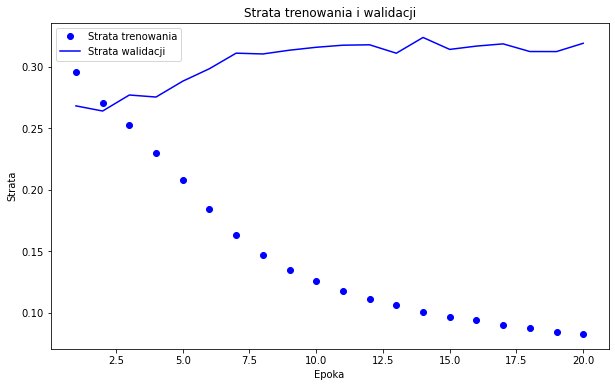

In [71]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'bo', label = 'Strata trenowania')
plt.plot(epochs, val_loss, 'b', label = 'Strata walidacji')
plt.legend()
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.savefig("./zdj_6_3/Loss_GRU_Bidirectional_128units.jpg")

In [72]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(4, input_shape=(None, float_data.shape[-1]))))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 15s 24ms/step - loss: 0.3526 - val_loss: 0.2860
Epoch 2/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2932 - val_loss: 0.2748
Epoch 3/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2844 - val_loss: 0.2715
Epoch 4/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2808 - val_loss: 0.2702
Epoch 5/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2804 - val_loss: 0.2704
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2795 - val_loss: 0.2654
Epoch 7/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2785 - val_loss: 0.2664
Epoch 8/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2761 - val_loss: 0.2652
Epoch 9/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2762 - val_loss: 0.2692
Epoch 10/20
500/500 [==============================] - 11s 23ms/step - loss: 0.275

In [73]:
min(val_loss)

0.2639491558074951

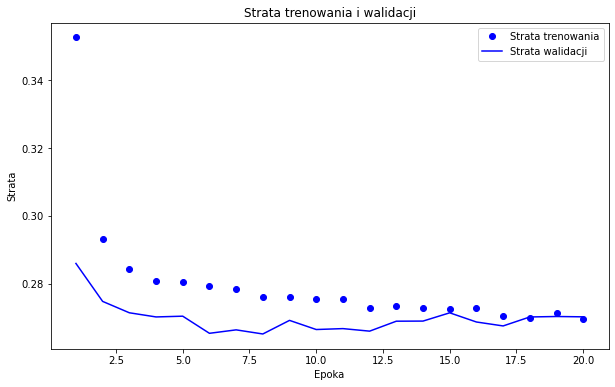

In [74]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'bo', label = 'Strata trenowania')
plt.plot(epochs, val_loss, 'b', label = 'Strata walidacji')
plt.legend()
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.savefig("./zdj_6_3/Loss_GRU_Bidirectional_4units.jpg")

In [75]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(16, input_shape=(None, float_data.shape[-1]))))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 15s 24ms/step - loss: 0.2998 - val_loss: 0.2795
Epoch 2/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2780 - val_loss: 0.2680
Epoch 3/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2745 - val_loss: 0.2684
Epoch 4/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2699 - val_loss: 0.2633
Epoch 5/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2684 - val_loss: 0.2612
Epoch 6/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2645 - val_loss: 0.2622
Epoch 7/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2616 - val_loss: 0.2675
Epoch 8/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2587 - val_loss: 0.2642
Epoch 9/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2562 - val_loss: 0.2651
Epoch 10/20
500/500 [==============================] - 12s 23ms/step - loss: 0.254

In [76]:
min(val_loss)

0.2652062177658081

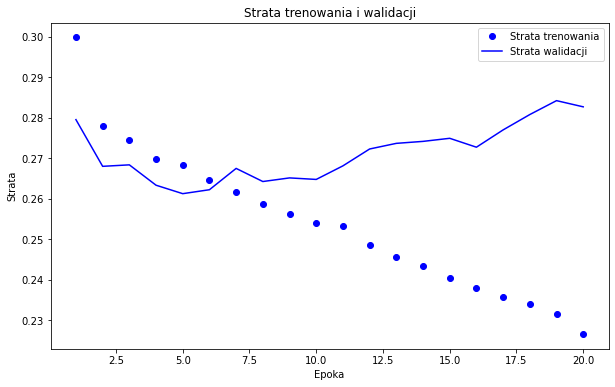

In [77]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'bo', label = 'Strata trenowania')
plt.plot(epochs, val_loss, 'b', label = 'Strata walidacji')
plt.legend()
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.savefig("./zdj_6_3/Loss_GRU_Bidirectional_16units.jpg")